# Python pour un Data Scientist : 
# Retrouver les pays à partir des discours prononcés à l'ONU
### Naïla El Haouari, Coline Fouché

# Introduction 

Depuis sa création en 1947, l'ONU accueille chaque année des représentants des Etats membres en Assemblée générale, afin de faciliter le dialogue entre les Etats. Ses objectifs sont les suivants : maintenir la paix et la sécurité internationale, protéger les droits de l'homme, fournir de l'aide alimentaire, promouvoir le développement durable, et garantir le droit international. Dès lors, des représentants des pays membres se doivent de tenir des discours présentant la politique de leur pays en relation et réaction avec les événements internationaux. Cependant, est-il possible de retrouver quel Etat parle en fonction de son discours ?

Les données à notre disposition proviennent du site Kaggle (https://www.kaggle.com/unitednations/un-general-debates) et comprennent le texte (en anglais) de tous les discours tenus en assemblée générale à l'ONU par les représentants des différents Etats membres des Nations Unies, par pays, entre 1970 et 2016. A l'aide de techniques de Data Science - et en particulier, en ayant recours au NLP pour étudier les discours plus en détail - nous avons construit un modèle de classification pour prévoir, à partir du discours, quel pays est représenté. Constatant qu'il nous fallait prédire 199 pays, contre seulement 6 continents, nous avons par la suite construit également un modèle de prédiction du continent d'origine des discours. Notre efficacité prédictive s'en est trouvé améliorée. Nous avons comparé plusieurs modèles mathématiques, ainsi que plusieurs paramètres, pour voir ce qui nous permettait de prédire au mieux ces deux éléments.

# 0. Ouverture des données

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
import nltk
import nltk.stem
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer, RegexpTokenizer
from nltk.corpus import stopwords

On charge les données

In [3]:
data= pd.read_csv("un-general-debates\\un-general-debates.csv")

In [4]:
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [5]:
data.describe(include="all")

,session,year,country,text
count,7507.000000,7507.000000,7507,7507
unique,NaN,NaN,199,7507
top,NaN,NaN,BOL,I would like to extend \nmy congratulations to...
freq,NaN,NaN,46,1
mean,49.610763,1994.610763,NaN,NaN
std,12.892155,12.892155,NaN,NaN
min,25.000000,1970.000000,NaN,NaN
25%,39.000000,1984.000000,NaN,NaN
50%,51.000000,1996.000000,NaN,NaN
75%,61.000000,2006.000000,NaN,NaN


# 1. Recodage et recherche de features

Notre base de données ne comprend qu'une seule variable susceptible de nous permettre de distinguer les pays entre eux : la variable "text", qui comprend tous les discours des représentants des pays de l'ONU. On cherchera diverses manières de caractériser les discours, pour obtenir plusieurs features pour notre modèle.

### Recodage des mots

On crée la variable "mots" qui est l'ensemble des mots du discours, en minuscule, sans signes de ponctuation

In [5]:
data['text'] = data['text'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
data['mots']=data['text'].apply(tokenizer.tokenize)

In [8]:
data.head()

,session,year,country,text,mots
0,44,1989,MDV,﻿it is indeed a pleasure for me and the member...,"[it, is, indeed, a, pleasure, for, me, and, th..."
1,44,1989,FIN,"﻿\nmay i begin by congratulating you. sir, on ...","[may, i, begin, by, congratulating, you, sir, ..."
2,44,1989,NER,"﻿\nmr. president, it is a particular pleasure ...","[mr, president, it, is, a, particular, pleasur..."
3,44,1989,URY,﻿\nduring the debate at the fortieth session o...,"[during, the, debate, at, the, fortieth, sessi..."
4,44,1989,ZWE,﻿i should like at the outset to express my del...,"[i, should, like, at, the, outset, to, express..."


La variable Clean regroupe quant à elle les mots de chaque discours, sans les mots de liaison ('it', 'I', 'and',...) qui sont inclus dans les stopwords.

In [6]:
stop_words = set(stopwords.words('english'))
data['clean'] = data['mots'].apply(lambda x: [w for w in x if w not in stop_words])

In [10]:
data.head()

,session,year,country,text,mots,clean
0,44,1989,MDV,﻿it is indeed a pleasure for me and the member...,"[it, is, indeed, a, pleasure, for, me, and, th...","[indeed, pleasure, members, delegation, extend..."
1,44,1989,FIN,"﻿\nmay i begin by congratulating you. sir, on ...","[may, i, begin, by, congratulating, you, sir, ...","[may, begin, congratulating, sir, election, pr..."
2,44,1989,NER,"﻿\nmr. president, it is a particular pleasure ...","[mr, president, it, is, a, particular, pleasur...","[mr, president, particular, pleasure, behalf, ..."
3,44,1989,URY,﻿\nduring the debate at the fortieth session o...,"[during, the, debate, at, the, fortieth, sessi...","[debate, fortieth, session, general, assembly,..."
4,44,1989,ZWE,﻿i should like at the outset to express my del...,"[i, should, like, at, the, outset, to, express...","[like, outset, express, delegation, satisfacti..."


On recherche des features pour faire notre classification. Il faut donc créer des variables qui distinguent les discours selon les pays.

### Longueur des phrases et des discours

La longueur des phrases et des discours (moyen par pays) peut varier selon les pays. La longueur moyenne des discours peut relever de l'implication d'un Etat au sein de l'ONU ou des affaires étrangères, mais aussi de la manière dont on tend à s'exprimer dans certains pays - ce qui tient davantage des particularités culturelles.

#### Construction des variables

In [7]:
data['nb_char'] = data['text'].str.len()
data['phrases'] = data['text'].str.split('.')
data['nb_mots'] = data['clean'].str.len() #On prend les mots clean, cad sans les petits mots de liaison
data['nb_phrases'] = data['phrases'].str.len()
data['long_mots'] = data['nb_char'] / data['nb_mots']
data['long_phrases'] = data['nb_mots'] / data['nb_phrases']

#### Représentation

In [8]:
a = data['nb_mots'].groupby(data['country']).mean()
print("Pays dont les discours comprennent en moyenne le plus et le moins de mots")
print(pd.concat([a.sort_values(ascending=False)[:10], a.sort_values(ascending=False)[-10:]], axis=0))
print()

print("Pays dont la phrase moyenne est la plus et la moins longue")
a = data['long_phrases'].groupby(data['country']).mean()
print(pd.concat([a.sort_values(ascending=False)[:10], a.sort_values(ascending=False)[-10:]], axis=0))
print()

Pays dont les discours comprennent en moyenne le plus et le moins de mots
country
RUS    2306.955556
IRL    2243.444444
CUB    2165.586957
LBY    2117.159091
EGY    2099.613636
USA    2053.826087
IRN    2030.065217
DEU    2029.813953
CSK    2004.000000
CHN    1915.933333
EU      891.200000
MNE     880.800000
SVN     869.833333
LTU     855.440000
TON     851.533333
PLW     847.888889
CHE     831.214286
UZB     827.350000
LIE     803.346154
BRN     596.387097
Name: nb_mots, dtype: float64

Pays dont la phrase moyenne est la plus et la moins longue
country
PRK    16.730872
BHR    16.676472
VAT    16.392160
VNM    16.161725
ARE    16.137100
MAR    16.114019
TUN    15.987226
MNE    15.973094
AGO    15.747415
GNQ    15.717641
NLD    10.397007
ISR    10.228552
NOR    10.190570
EU     10.189172
GBR    10.161099
CHE    10.142022
BRN     9.926188
FIN     9.885724
DEU     9.766697
SWE     9.736479
Name: long_phrases, dtype: float64



On observe ainsi que la longueur moyenne d'une phrase diffère relativement bien selon les pays, ainsi que la longueur du discours (nombre de mots).

In [12]:
print(data['nb_char'].describe())
print(data['nb_mots'].describe())
print(data['nb_phrases'].describe())
print(data['long_mots'].describe())
print(data['long_phrases'].describe())

count     7507.000000
mean     17967.281604
std       7860.038463
min       2362.000000
25%      12077.000000
50%      16424.000000
75%      22479.500000
max      72041.000000
Name: nb_char, dtype: float64
count    7507.000000
mean     1531.117091
std       664.527140
min       198.000000
25%      1035.000000
50%      1399.000000
75%      1911.000000
max      6019.000000
Name: nb_mots, dtype: float64
count    7507.000000
mean      119.774477
std        59.170509
min        23.000000
25%        78.000000
50%       106.000000
75%       149.000000
max       591.000000
Name: nb_phrases, dtype: float64
count    7507.000000
mean       11.722654
std         0.299497
min        10.360563
25%        11.539012
50%        11.737028
75%        11.922650
max        12.864909
Name: long_mots, dtype: float64
count    7507.000000
mean       13.257359
std         2.518202
min         6.896552
25%        11.444444
50%        13.006135
75%        14.831472
max        26.835294
Name: long_phrases, dtype: 

On pourra utiliser comme features la longueur des discours (nb_mots ou nb_charactère) et la longueur des phrases.

## Richesse et diversité du langage

A présent, on cherchera si beaucoup de mots différents sont employés dans les discours ou non, selon les Pays, c'est-à-dire s'il est propre à certains pays de recourir à davantage de vocabulaire que d'autres.

### Création des variables

Pour juger de la diversité du langage, on va utiliser stems : on prend la racine des mots, pour pouvoir les comparer entre eux (qu'ils soient au pluriel ou non, sous une certaine forme ou non). On construit les variables de racine de mot à partir des variables "clean", car on exclut les mots de liaison, qui ne témoignent pas de la richesse d'un langage.

In [9]:
stemmer=nltk.stem.PorterStemmer()
data['stems'] = [[format(stemmer.stem(token)) for token in speech] for speech in data['clean']]

Puisqu'il y a beaucoup de nombres parmi les mots (et même dans les racines), on supprime les nombres.

In [10]:
data['stems'] = data['stems'].apply(lambda x: [w for w in x if not w.isdigit()])

On calcule enfin la richesse lexicale comme le rapport du nombre de mots uniques par discours par le nombre total de mots (les mots sont les racines des mots).

In [15]:
def rich_voc(text):
    return len(set(text)) / len(text)

In [16]:
data["richesse_voc"]=0
for i in range (len(data)) :
    data.ix[i, "richesse_voc"]=rich_voc(data.ix[i, "stems"])

C:\Users\Naïla\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


### Résultats pas probants

In [17]:
data['richesse_voc'].groupby(data['country']).mean()

country
AFG     0.477972
AGO     0.483057
ALB     0.434654
AND     0.539584
ARE     0.474855
ARG     0.471981
ARM     0.556558
ATG     0.509836
AUS     0.435122
AUT     0.473663
AZE     0.499643
BDI     0.472576
BEL     0.482897
BEN     0.473453
BFA     0.532548
BGD     0.501927
BGR     0.468439
BHR     0.445505
BHS     0.498236
BIH     0.518341
BLR     0.450883
BLZ     0.541358
BOL     0.482723
BRA     0.501468
BRB     0.497333
BRN     0.579686
BTN     0.550499
BWA     0.504144
CAF     0.496729
CAN     0.471663
          ...   
SYR     0.467605
TCD     0.505743
TGO     0.487498
THA     0.465370
TJK     0.467295
TKM     0.477988
TLS     0.515150
TON     0.536762
TTO     0.461865
TUN     0.450991
TUR     0.473079
TUV     0.492028
TZA     0.457466
UGA     0.484450
UKR     0.455485
URY     0.477731
USA     0.432939
UZB     0.547033
VAT     0.521398
VCT     0.550948
VEN     0.485016
VNM     0.449490
VUT     0.492858
WSM     0.520228
YDYE    0.447169
YEM     0.462285
YUG     0.462207
ZAF   

In [18]:
data.richesse_voc.describe() #c'est peu probant

count    7507.000000
mean        0.485536
std         0.069847
min         0.262552
25%         0.436968
50%         0.485742
75%         0.533172
max         0.812298
Name: richesse_voc, dtype: float64

In [19]:
data.groupby('country').mean()

,session,year,nb_char,nb_mots,nb_phrases,long_mots,long_phrases,richesse_voc
country,,,,,,,,
AFG,48.000000,1993.000000,19236.377778,1640.311111,120.955556,11.746851,13.835943,0.477972
AGO,51.447368,1996.447368,16864.763158,1423.236842,91.263158,11.866168,15.747415,0.483057
ALB,47.500000,1992.500000,21851.652174,1825.934783,128.500000,11.924952,14.327887,0.434654
AND,59.500000,2004.500000,12999.636364,1104.272727,87.909091,11.768000,12.684431,0.539584
ARE,48.500000,1993.500000,14796.159091,1249.181818,83.272727,11.828606,16.137100,0.474855
ARG,47.500000,1992.500000,21165.978261,1760.891304,136.760870,12.020431,13.305347,0.471981
ARM,58.500000,2003.500000,11009.083333,933.291667,68.291667,11.822994,13.768230,0.556558
ATG,54.281250,1999.281250,17550.156250,1511.843750,113.406250,11.638739,13.411718,0.509836
AUS,47.500000,1992.500000,21722.804348,1869.043478,157.782609,11.560512,12.121347,0.435122


## Mots utilisés dans les différents discours

Les pays ont des thématiques propres à eux, et emploient des expressions qui reviennent avec plus ou moins de récurrence dans les discours et différemment selon les pays. On cherche donc à créer des variables permettant de donner le poids des mots ou expressions dans les discours.

On crée des variables TF-IDF donnant le poids de chaque bigram dans les discours :

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create 500 TF-IDF features, using 2-gram
num_features = 500
tfidf = TfidfVectorizer(max_features = num_features, strip_accents='unicode',
                        lowercase=True, stop_words='english', ngram_range=(1,2))
print('Fitting Data...')
tfidf.fit(data['text'].values.astype('U'))

print('Starting Transform...')
text_tfidf = tfidf.transform(data['text'])

print('Label and Incorporate TF-IDF...')
data_array = pd.DataFrame(text_tfidf.toarray())
feature_names = tfidf.get_feature_names()

for i in range(num_features):
    feature_names[i] = 'TF_' + feature_names[i]

data_array.columns = feature_names
data = pd.concat([data, data_array], axis=1)

data[:2]

Fitting Data...
Starting Transform...
Label and Incorporate TF-IDF...


,session,year,country,text,mots,clean,nb_char,phrases,nb_mots,nb_phrases,...,TF_welcome,TF_west,TF_western,TF_wish,TF_women,TF_work,TF_working,TF_world,TF_year,TF_years
0,44,1989,MDV,﻿it is indeed a pleasure for me and the member...,"[it, is, indeed, a, pleasure, for, me, and, th...","[indeed, pleasure, members, delegation, extend...",19023,[﻿it is indeed a pleasure for me and the membe...,1586,125,...,0.170188,0.0,0.0,0.000000,0.0,0.000000,0.0,0.05723,0.052586,0.064732
1,44,1989,FIN,"﻿\nmay i begin by congratulating you. sir, on ...","[may, i, begin, by, congratulating, you, sir, ...","[may, begin, congratulating, sir, election, pr...",17396,"[﻿\nmay i begin by congratulating you, sir, o...",1491,130,...,0.047947,0.0,0.0,0.029169,0.0,0.024407,0.0,0.09674,0.148148,0.000000


In [12]:
#On visualise la liste des mots ainsi créés
features = data.columns.tolist()
for i in ['session','year','country','text','mots','clean', 'stems']:
    features.remove(i)
features

['nb_char',
 'phrases',
 'nb_mots',
 'nb_phrases',
 'long_mots',
 'long_phrases',
 'stems',
 'TF_10',
 'TF_able',
 'TF_accordance',
 'TF_achieve',
 'TF_achieved',
 'TF_act',
 'TF_action',
 'TF_actions',
 'TF_active',
 'TF_activities',
 'TF_acts',
 'TF_address',
 'TF_adopted',
 'TF_adoption',
 'TF_affairs',
 'TF_afghanistan',
 'TF_africa',
 'TF_african',
 'TF_agenda',
 'TF_aggression',
 'TF_ago',
 'TF_agreement',
 'TF_agreements',
 'TF_aid',
 'TF_aimed',
 'TF_aligned',
 'TF_allow',
 'TF_america',
 'TF_american',
 'TF_apartheid',
 'TF_appeal',
 'TF_approach',
 'TF_appropriate',
 'TF_arab',
 'TF_area',
 'TF_areas',
 'TF_armed',
 'TF_arms',
 'TF_arms race',
 'TF_asia',
 'TF_aspirations',
 'TF_assembly',
 'TF_assistance',
 'TF_attention',
 'TF_aware',
 'TF_based',
 'TF_basic',
 'TF_basis',
 'TF_behalf',
 'TF_believe',
 'TF_best',
 'TF_better',
 'TF_bring',
 'TF_brought',
 'TF_build',
 'TF_building',
 'TF_called',
 'TF_capacity',
 'TF_case',
 'TF_cause',
 'TF_cent',
 'TF_central',
 'TF_centu

# 2. Classification

Désormais, on peut faire notre classification. L'objectif est de construire un modèle permettant de prédire si l'on peut retrouver le pays à partir du discours.

## Préparation du modèle

On construit à partir du data frame des arrays numpy pour pouvoir utiliser le module scikit learn

In [35]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

On choisir de ne garder comme features que les TF-variables (les indicateurs du poids de chaque mot dans les discours. En effet, nous avions essayé d'inclure les variables de longueur de discours et de phrases, propres davantage à la manière de s'exprimer, mais celles-ci baissaient énormément le score dans nos modèles.

In [54]:
X = data.drop( ['session','year','country','text','mots','clean', 'stems', 'nb_char','nb_mots','phrases','nb_phrases','long_mots','long_phrases'],axis=1)
y = data['country'] 

In [55]:
#transformation en arrays numpy

X = X.as_matrix()

lb_make = LabelEncoder()
y = lb_make.fit_transform(y)
#recode les pays en entiers, par ordre alphabétique

## Séparation de la base en données d'entraînement et données de test

On construit nos deux bases en veillant à bien conserver tous les pays dans les mêmes proportions dans chaque base.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
#l'option stratify sert à garder la même proportion de chaque classe (ici, les pays) dans la base train et la base test

In [60]:
len(y_test)

1877

## Tests de modèles de classification

On construit différents modèles de classification, afin de comparer les tester sur notre base, et de comparer les résultats entre eux. On utilise les modèles mutinomalNB et LinéaireSVC

In [106]:
#Fonction de classification selon plusieurs modèles : 

def classification (model):
    # on entraîne le modèle
    clf = model
    clf.fit(X_train, y_train)
    
    # on prédit les labels des données test
    predicted = clf.predict(X_test)
    expected = y_test
    
    print(predicted) 
    print(expected) 
    
    #on compte le nombre de discours pour lesquels le modèle devine juste
    nb_juste = 0
    for i in range(len(predicted)):
        if predicted[i] == expected[i]:
            nb_juste += 1
    print(nb_juste)
    
    #on calcule le score du modèle = pourcentage de réponses justes sur les données test
    print(clf.score(X_test, y_test))

In [107]:
#Essai avec les modèles multinomalNB et linéaireSVC
classification(MultinomialNB())
classification(LinearSVC())

[ 24 182 183 ...,  79 129  28]
[  7 182  20 ...,  79 129  63]
782
0.416622269579
[177 125 183 ...,  79 129  28]
[  7 182  20 ...,  79 129  63]
1324
0.705380927011


A l'aide des deux modèles de classification, on a pu prédire les pays avec des résultats différents. Le modèle multinomial prédit avec justesse 782 pays sur les 1877 de notre base test (c'est-à-dire 40% de la base test), et le modèle linéaire a de meilleurs résultats, avec 70% de prédiction de pays juste. Le modèle linéaire est donc assez bon et a l'air de mieux correspondre à nos données.

## Essai de prédiction du continent plutôt que du pays

Bien que l'on obtienne de bons résultats de prédiction de pays avec nos modèles de classification, on cherche à savoir s'il est possible de prédire le continent. On aurait moins de classes à trouver (6, car on considère l'Amérique du Nord et l'Amérique du Sud comme deux continents distincts). Pour ce faire, il faut supposer que les pays appartenant à un même continent font leurs discours sur des thématiques assez proches, hypothèse qui est tout à fait envisageable.

### Création des variables de continent

In [61]:
import pycountry_convert as pc

#création d'une variable continent
#passage par le code en 2 lettres car le module pycountry-convert ne permet pas de passer du code en 3 lettres au continent
data['continent'] = data['country'].apply(lambda x : pc.country_alpha3_to_country_alpha2(x) if len(x)==3 and x not in ['CSK','YUG','DDR'] else x)
#conversion en continent, en enlevant les valeurs qui donnent une erreur
data['continent'] = data['continent'].apply(lambda x : pc.country_alpha2_to_continent_code(x) if (len(x)==2) and x not in ['EU', 'TL','VA'] else x)
#traitement des valeurs d'erreur en recherchant le pays à la main
data['continent'] = data['continent'].replace('YUG','EU') #Yougoslavie
data['continent'] = data['continent'].replace('CSK','EU') #Tchécoslovaquie
data['continent'] = data['continent'].replace('YDYE','AF') #République Démocratique du Yémen
data['continent'] = data['continent'].replace('DDR','EU') #RDA
data['continent'] = data['continent'].replace('TL','AS') #Timor oriental
data['continent'] = data['continent'].replace('VA','EU') #Vatican

In [62]:
data['continent'].value_counts()

AF    2178
AS    1839
EU    1622
NA     934
SA     540
OC     394
Name: continent, dtype: int64

In [235]:
continents = pd.DataFrame(y2,data['continent'])
continents = continents.drop_duplicates()
#table pour associer les numéros aux codes de continent, numéros attribués par ordre alphabétique

In [63]:
y2 = data['continent']
y2 = lb_make.fit_transform(y2)

### Prédiction du continent

On sépare notre base en test et train, toujours avec l'option stratify, puis on fait plusieurs modèles de classification.

In [64]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.25, stratify=y2)

In [65]:
#Fonction de classification selon plusieurs modèles : 

def classification2 (model):
    # on entraîne le modèle
    clf = model
    clf.fit(X_train2, y_train2)
    
    # on prédit les labels des données test
    predicted = clf.predict(X_test2)
    expected = y_test2
    
    print(predicted) 
    print(expected) 
    
    #on compte le nombre de discours pour lesquels le modèle devine juste
    nb_juste = 0
    for i in range(len(predicted)):
        if predicted[i] == expected[i]:
            nb_juste += 1
    print(nb_juste)
    
    #on calcule le score du modèle = pourcentage de réponses justes sur les données test
    print(clf.score(X_test2, y_test2))

In [66]:
classification2(MultinomialNB())
classification2(LinearSVC())

[1 0 1 ..., 0 2 0]
[0 3 1 ..., 0 1 3]
1335
0.711241342568
[1 5 1 ..., 0 1 1]
[0 3 1 ..., 0 1 3]
1666
0.887586574321


Les résultats de nos classifications à partir des continents sont meilleurs qu'avec nos pays : cela est à priori assez logique, puisque l'on a 6 classes au lieu de 199 précédemment, ce qui diminue considérablement le risque d'erreurs. Les deux modèles, multinomial et linéaire, affichent ici de très bons résultats, puisqu'il permettent de prédire jusqu'à 90% des classes de notre base test. Ces résultats témoignent par ailleurs de similarités entre les discours des différents pays d'un même continent, en ce qui concerne les termes et expressions employés par les représentants de l'ONU.

# 3. Cross-validation

Nos modèles ont des résultats relativement bons : ils permettent de prédire les pays pour jusqu'à 70% des discours, et les continents pour jusqu'à près de 90% des discours. Cependant, pour justifier de la validité de nos modèles, nous devons nous pencher sur un autre problème, qui est celui du risque de surapprentissage, ou "overfitting", de nos modèles. En effet, si un modèle apprend "trop" bien sur la base d'entraînement (on parle parfois d'apprentissage "par coeur" des données, le modèle décrit parfaitement les données de la base train), il risque de perdre de son pouvoir de prédiction sur la base de test.

Pour vérifier si notre modèle est bien ajusté, ou s'il est overfitted, on utilise la technique de cross-validation. 

On n'effectue la cross-validation que sur le modèles linéaire, car il a un pouvoir de prédiction bien meilleur que le modèle multinomial.

## Pour les pays

In [221]:
from sklearn.model_selection import cross_val_score
clf = LinearSVC()
scores = cross_val_score(clf, X_train, y_train, cv=4) 
#on ne peut pas faire cv>4 car les classes les moins représentées n'ont que 4 occurrences dans X_train
scores

array([ 0.64772727,  0.64109589,  0.64391691,  0.64705882])

In [222]:
scores.mean()

0.64494972515355775

In [223]:
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.70538092701118804

On effectue une cross-validation selon différents paramètres

#### Selon le paramètre d'erreur C

In [224]:
from sklearn.model_selection import validation_curve 

degres = np.arange(0.5, 4, step=0.5)
model=LinearSVC()
    
train_scores, validation_scores = validation_curve(
                 model, X_train, y_train,
                 param_name='C',
                 param_range=degres)

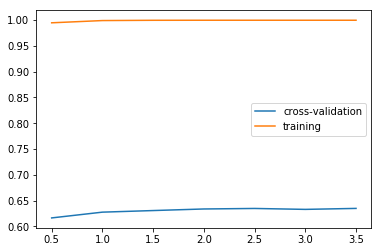

In [225]:
plt.plot(degres, validation_scores.mean(axis=1), label='cross-validation')  
plt.plot(degres, train_scores.mean(axis=1), label='training') # proche de 1 : prédit presque parfaitement les données train

plt.legend(loc='best')  

#### Selon le paramètre max_iter 

In [226]:
iterations = np.arange(500, 2500, step=500)
model=LinearSVC()
    
train_scores, validation_scores = validation_curve(
                 model, X_train, y_train,
                 param_name='max_iter',
                 param_range=iterations)

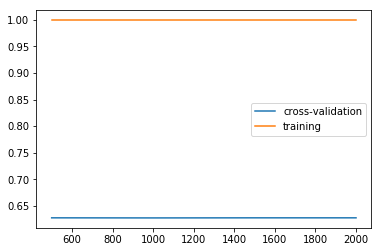

In [227]:
plt.plot(iterations, validation_scores.mean(axis=1), label='cross-validation')  
plt.plot(iterations, train_scores.mean(axis=1), label='training') 

plt.legend(loc='best') 

Le score ne change quasiment pas avec la variation du paramètre d'itérations.

#### En enlevant le calcul de l'intercept

In [228]:
clf = LinearSVC(fit_intercept=False)
scores = cross_val_score(clf, X_train, y_train, cv=4) #on ne peut pas faire c>4 car les classes les moins représentées n'ont que 4 occurrences dans X_train
scores.mean() #valait 0.65 avec intercept

0.64119755883636842

On observe que le modèle est légèrement overfitted : le score est plus élevé pour la base de training que pour la cross-validation, et ce peu importe les paramètres. Par conséquent, on décide de conserver les paramètres par défaut, notamment C=1 qui minimise tout de même l'over-fitting.

## Pour les continents

In [229]:
clf = LinearSVC()
scores = cross_val_score(clf, X_train2, y_train2, cv=5)
scores

array([ 0.88308237,  0.87566607,  0.87388988,  0.88      ,  0.87989324])

In [230]:
scores.mean()

0.87850631249654021

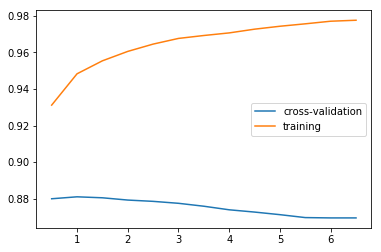

In [231]:
degres = np.arange(0.5, 7, step=0.5)
model=LinearSVC()
    
train_scores, validation_scores = validation_curve(
                 model, X_train2, y_train2,
                 param_name='C',
                 param_range=degres)

plt.plot(degres, validation_scores.mean(axis=1), label='cross-validation')  
plt.plot(degres, train_scores.mean(axis=1), label='training') 

plt.legend(loc='best')  

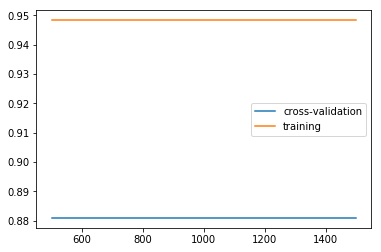

In [232]:
iterations = np.arange(500, 2000, step=500)
model=LinearSVC()
    
train_scores, validation_scores = validation_curve(
                 model, X_train2, y_train2,
                 param_name='max_iter',
                 param_range=iterations)

plt.plot(iterations, validation_scores.mean(axis=1), label='cross-validation')  
plt.plot(iterations, train_scores.mean(axis=1), label='training') 

plt.legend(loc='best') 

De même que pour la prédiction des pays, la variation du paramètre du maximum d'itérations ne change presque rien au score du modèle linéaire.

In [233]:
clf = LinearSVC(fit_intercept=False)
scores = cross_val_score(clf, X_train2, y_train2, cv=5) 
scores.mean() #valait 0.88 avec intercept -> change très peu

0.87796998075029753

Le modèle linéaire pour les continents est également légèrement overfitted, mais beaucoup moins que celui des pays. On choisit également de conserver les paramètres par défaut car ils minimisent l'overfit.

# 4. Comparaison des deux modèles dans la prédiction des pays

On veut savoir dans quelle mesure les deux modèles auxquels ont a eu recours pour notre classification sur les pays prédisent de la même manière.

On récupère tout d'abord les valeurs des scores prédits.

In [113]:
clf=MultinomialNB()
clf.fit(X_train, y_train)
multi=clf.predict(X_test)
clf=LinearSVC()
clf.fit(X_train, y_train)
lin=clf.predict(X_test)

On cherche d'abord dans quelle mesure les deux modèles sont en accord

In [245]:
compa=multi==lin

i=0
for comp in compa :
    if comp :
        i+=1
print("Proportion d'accord entre les deux modèles : "+ str(i/len(compa)) )

Proportion d'accord entre les deux modèles : 0.4805540756526372


Par conséquent, le modèle linéaire et le modèle multinomial sont en accord dans près de la moitié des cas. Dans la mesure où le modèle multinomial prédisait justement dans 41% des cas, cela signifie qu'il y a des cas où les deux modèles sont en accord mais en ayant tort (ils prédisent tous les deux le même pays, mais pas le bon). Il peut également y avoir des cas où l'un des modèles a raison et l'autre a tort.

### Cas où l'un des modèles seulement a raison

On veut savoir si des pays reviennent parmi les cas mal prédits par l'un, l'autre, ou les deux modèles, afin de voir si certaines catégories de pays sont trop difficiles à classer pour nos modèles.

#### Quand le modèle multinomial prédit mieux que le modèle linéaire

On s'intéresse au cas où le modèle multinomial prédit justement, et le modèle linéaire (qui réussit bien mieux que le modèle multinomial) a tort. On suppose que ce cas est assez rare, puisqu'on suppose que les pays prédits justement par le modèle multinomials sont aussi ceux où le modèle linéaire a raison.

In [135]:
multi_raison=y_test==multi
lin_tort=y_test!=lin

i=0
diff_multi_raison=[]
for j in range(len(multi_raison)) :
    if multi_raison[j] :
        if lin_tort[j]:
            i+=1
            diff_multi_raison.append(y_test[j])
            
            
print("Proportion de cas où multi a raison et lin a tort : "+ str(i/len(y_test))
     +"\nEffectivement, on a très peu de cas où le modèle multinomial a raison et le modèle linéaire a tort")

Proportion de cas où multi a raison et lin a tort : 0.03090037293553543
Effectivement, on a très peu de cas où le modèle multinomial a raison et le modèle linéaire a tort


On va chercher dans quels pays le modèle multinomial a raison, et le modèle linéaire tort, et si ça revient dans certains cas

In [151]:
from collections import Counter
c1= Counter(diff_multi_raison).most_common(5)
c1

[(29, 4), (129, 3), (62, 3), (88, 3), (24, 3)]

In [205]:
d = {'code': y, 'nom_pays': data['country']}
pays=pd.DataFrame(data=d)
pays=pays.drop_duplicates()
print(pays[pays.code ==29])
print(pays[pays.code ==129])
print(pays[pays.code ==62])
print(pays[pays.code ==88])
print(pays[pays.code ==24])

    code nom_pays
25    29      CAN
     code nom_pays
132   129      NGA
     code nom_pays
262    62      FSM
     code nom_pays
130    88      JOR
    code nom_pays
84    24      BRB


On peut repérer les pays que le modèle multinomial arrive mieux à classifier, tels que le Canada, le Nigéria, la Jordanie.

#### Cas où le modèle linéaire prédit mieux que le modèle multinomial

Cherchons maintenant les cas où le modèle linéaire a raison mais le modèle multinomial a tort

In [141]:
lin_raison=y_test==lin
multi_tort=y_test!=multi

i=0
diff_lin_raison=[]
for j in range(len(lin_raison)) :
    if lin_raison[j] :
        if multi_tort[j]:
            i+=1
            diff_lin_raison.append(y_test[j])
            
            
print("Proportion de cas où lin a raison et multi a tort : "+ str(i/len(y_test))
      +"\nC'est à dire que dans 31% des cas, le modèle linéaire est le seul à avoir raison")

Proportion de cas où lin a raison et multi a tort : 0.3196590303676079
C'est à dire que dans 31% des cas, le modèle linéaire est le seul à avoir raison


In [208]:
c2= Counter(diff_lin_raison).most_common(10)
c2

[(27, 8),
 (1, 8),
 (160, 8),
 (143, 7),
 (78, 7),
 (122, 7),
 (156, 7),
 (163, 7),
 (118, 7),
 (105, 7)]

In [209]:
print(pays[pays.code ==27])
print(pays[pays.code ==1])
print(pays[pays.code ==160])
print(pays[pays.code ==143])
print(pays[pays.code ==78])

    code nom_pays
90    27      BWA
    code nom_pays
45     1      AGO
     code nom_pays
146   160      SOM
    code nom_pays
88   143      POL
    code nom_pays
86    78      HUN


Et les pays que seul le modèle linéaire arrive mieux à prédire, tels que Botswana, Pologne, Angola

### Cas où les deux modèles se trompent

A présent, cherchons s'il y a des pays pour lesquels aucun des deux modèles n'arrive à faire une prédiction juste.

In [246]:
lin_tort=y_test!=lin
multi_tort=y_test!=multi

i=0
tort=[]
for j in range(len(lin_tort)) :
    if lin_tort[j] :
        if multi_tort[j]:
            i+=1
            tort.append(y_test[j])
            
            
print("Proportion de cas où les deux modèles se trompent : "+ str(i/len(y_test))
      +"\nC'est à dire que dans 26% des cas, aucun modèle n'a raison")

Proportion de cas où les deux modèles se trompent : 0.2637187000532765
C'est à dire que dans 26% des cas, aucun modèle n'a raison


In [220]:
c3= Counter(tort).most_common(40)
c3

[(151, 10),
 (128, 9),
 (139, 9),
 (158, 8),
 (66, 8),
 (117, 8),
 (69, 8),
 (36, 7),
 (13, 7),
 (130, 7),
 (73, 7),
 (29, 7),
 (33, 7),
 (14, 7),
 (34, 7),
 (197, 6),
 (106, 6),
 (168, 6),
 (157, 6),
 (112, 6),
 (132, 6),
 (167, 6),
 (131, 5),
 (182, 5),
 (56, 5),
 (18, 5),
 (125, 5),
 (8, 5),
 (16, 5),
 (52, 5),
 (63, 5),
 (126, 5),
 (12, 5),
 (162, 5),
 (124, 5),
 (26, 5),
 (7, 4),
 (20, 4),
 (198, 4),
 (114, 4)]

In [214]:
print(pays[pays.code ==151])
print(pays[pays.code ==128])
print(pays[pays.code ==139])
print(pays[pays.code ==158])
print(pays[pays.code ==66])
print(pays[pays.code ==117])
print(pays[pays.code ==69])
print(pays[pays.code ==36])
print(pays[pays.code ==13])
print(pays[pays.code ==130])

    code nom_pays
24   151      RWA
   code nom_pays
2   128      NER
     code nom_pays
127   139      PER
    code nom_pays
12   158      SLV
    code nom_pays
79    66      GHA
    code nom_pays
75   117      MLI
    code nom_pays
89    69      GNB
     code nom_pays
131    36      COG
     code nom_pays
145    13      BEN
    code nom_pays
96   130      NIC


Finalement, il n'y a pas de "gros pays" (ie qui a fait des discours 40 fois à l'ONU) qui n'a pas été prédit du tout. Le pays qui a le plus de valeurs mal prédites par les deux modèles est le Rwanda. 

# Conclusion

Nous avons construit un modèle qui prédit relativement bien le pays (par rapport au nombre de pays différents possibles), et très bien le continent (plus facile à prédire car le modèle a une chance sur 6 de tomber juste). L'over-fit est plus important pour le pays que pour le continent, ce qui était attendu. On aurait pu tenter de le réduire dans le premier cas en réduisant par exemple le nombre de features, mais la construction de nos features a été très coûteuse en temps et nous avons préféré les conserver, pour ne pas perdre d'information pour le modèle de prédiction du continent. Notre modèle est donc raisonnablement exploitable, si l'on ne craint pas les conséquences diplomatiques que pourrait créer une erreur de prédiction. 

Il aurait sans doute été enrichissant pour notre modèle d'avoir davantage de données à notre disposition. Cependant, au vu du coût de certaines méthodes qui ont parfois tourné plus de 10 minutes, notre programme ne supporterait pas forcément une forte augmentation de la taille de l'échantillon. De plus, nous avons choisi de ne pas tenir compte de la date des discours pour notre analyse, mais remonter plus loin dans le temps pour collecter des discours aurait pu apporter un biais au modèle car les pays ont pu changer de politique, et on peut se douter qu'il y a eu depuis 1945 une évolution des termes employés, avec par exemple l'apparition du champ lexical du terrorisme ou du réchauffement climatique. 

Notre modèle donne une idée de l'importance du discours dans la représentation de l'identité d'un pays. Chaque pays a sa propre façon de s'exprimer, et cela est encore plus vrai à propos des continents : notre analyse nous permet donc d'explorer également les possibles proximités entre les pays, et plus seulement ce qui les distingue.


# Annexe 

ACP : proximités entre les pays
           0
continent   
AF         0
AS         1
EU         2
NA         3
OC         4
SA         5


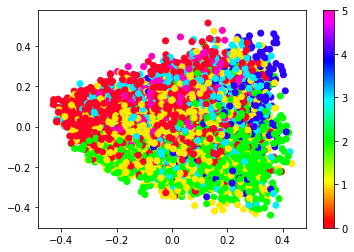

In [244]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(X)
plt.scatter(proj[:, 0], proj[:, 1], c=y2, cmap='gist_rainbow') 
plt.colorbar() 
print('ACP : proximités entre les pays')
print(continents.sort_index())